In [77]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl


import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline 
%load_ext autoreload                                                                                                                                                                                                
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
%load_ext autoreload
%autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
if not os.path.isdir('DampedNewtonlogexpstabilizationtests_images'):
    os.makedirs('DampedNewtonlogexpstabilizationtests_images')


In [80]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [81]:
def generate_data(N):
    """
     N is a list of the size of the data on x and y
    """
    x = np.random.rand( 2,N[0] )-0.5
    theta = 2*np.pi*np.random.rand( 1,N[1] )
    r = 0.8+.2*np.random.rand( 1,N[1] )
    y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )
    return x,y

In [82]:
import computational_OT

# Comparing between Sinkhorn with and without log-domain regularization


In [83]:
N = [ 500,600 ]
x,y = generate_data(N)

## Log-domain sinkhorn

In [84]:
a = normalize(np.ones(N[0]))
b = normalize(np.ones(N[1]))

In [85]:
def mina_u(H,epsilon): 
    return -epsilon*np.log( np.sum(a[:,None] * np.exp(-H/epsilon),0) )
def minb_u(H,epsilon):
    return -epsilon*np.log( np.sum(b[None,:] * np.exp(-H/epsilon),1) )

def mina(H,epsilon): return mina_u(H-np.min(H,0),epsilon) + np.min(H,0);
def minb(H,epsilon): return minb_u(H-np.min(H,1)[:,None],epsilon) + np.min(H,1);



In [86]:
def log_sinkhorn(a,b, C,epsilon,f, tol = 1e-14, niter = 500):    
    Err = []
    for i in range(niter):
        g = mina(C-f[:,None],epsilon)
        f = minb(C-g[None,:],epsilon)
        # generate the coupling
        P = a[:,None]*np.exp((f[:,None]+g[None,:]-C)/epsilon) * b[None,:] # line (*)
        # check conservation of mass
        Err.append( np.linalg.norm(np.sum(P,0)-b,1) )
        if Err[i] < tol:
            print("Terminating after iteration: ",i+1)
            break
    return {
        'error'      : Err,
        'potential_f': f+epsilon*np.log(a),
        'potential_g': g+epsilon*np.log(b)  #Change of convention because of line (*)
    }


In [87]:
# Log domain Sinkhorn
print("Log domain Sinkhorn.... ")
results_logSinkhorn = []
times_logSinkhorn   = []
logsinkhornP        = []
epsilons            = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03, 0.02, 0.01, 0.005]
# epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03, 0.02, 0.001]
# epsilons = [1.0]
for eps in epsilons:

  print( "Sinkhorn for epsilon = "+str(eps)+":" )    
  
  #Cost matrix
  C = distmat(x,y)


  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

  start = time.time()
  output = log_sinkhorn( a,b, C, eps, a, niter = 10000 )
  results_logSinkhorn.append( output )
  end = time.time()
  times_logSinkhorn.append(1e-3*(end-start) )
  logsinkhornP.append(GetP(output['potential_f']/eps, np.exp(-C/eps),output['potential_g']/eps))

Log domain Sinkhorn.... 
Sinkhorn for epsilon = 1.0:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  14
Sinkhorn for epsilon = 0.5:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  25
Sinkhorn for epsilon = 0.3:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  45
Sinkhorn for epsilon = 0.1:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  148
Sinkhorn for epsilon = 0.09:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  166
Sinkhorn for epsilon = 0.05:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  303
Sinkhorn for epsilon = 0.03:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  508
Sinkhorn for epsilon = 0.02:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  765
Sinkhorn for epsilon = 0.01:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1559
Sinkhorn for epsilon = 0.005:
Doing for ( 500 600 ).
 |- Iterating
Terminating af

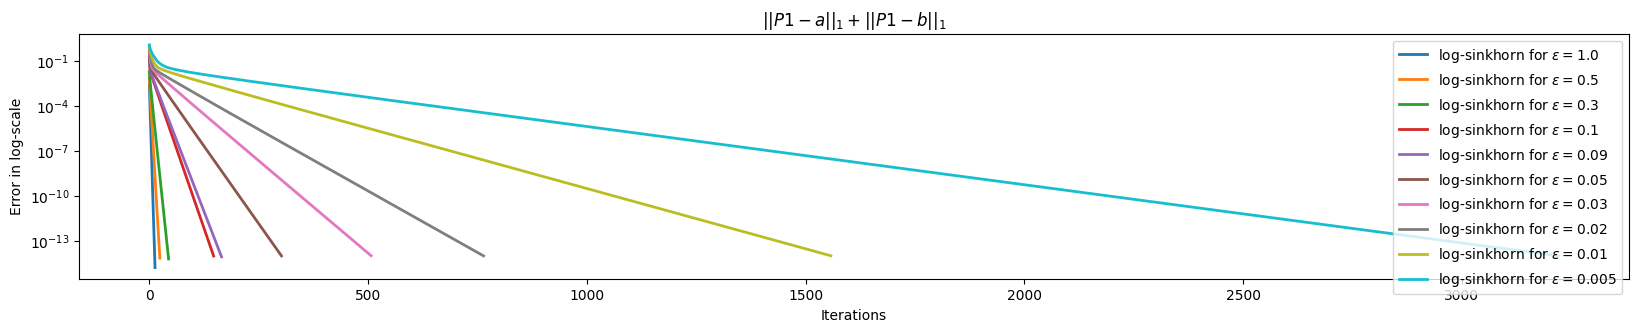

In [88]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len( results_logSinkhorn) ):
  error = np.asarray( results_logSinkhorn[i]['error'])
  plt.plot( error, label = 'log-sinkhorn for $\epsilon=$'+ str(epsilons[i]) , linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")
plt.show()


In [89]:
flogsinkhorn, glogsinkhorn = [], []
for i in range(len(results_logSinkhorn)):
    flogsinkhorn.append(results_logSinkhorn[i]['potential_f'])
    glogsinkhorn.append(results_logSinkhorn[i]['potential_g'])



## Sinkhorn

In [90]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP=[]
results_Sinkhorn=[]
times_Sinkhorn=[]
epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03, 0.02, 0.01, 0.005]
Pmatrix_dist_linVSsinkhorn=[]
 # a and b
a = normalize(np.ones(N[0]))
a=a.reshape(a.shape[0],-1)
b = normalize(np.ones(N[1]))
b=b.reshape(b.shape[0],-1)

for eps in epsilons:

  
  #Cost matrix
  C = distmat(x,y)
  
 


  #Kernel
  K=np.exp(-C/eps)


  print("Doing for (",N[0],N[1],").")
  print( " |- Iterating")

  #Inflating
  u=a
  v=b

  start=time.time()
  Optimizer=computational_OT.Sinkhorn(K,a,b,u,v,eps)
  out=Optimizer._update()
  results_Sinkhorn.append(out)
  end=time.time()
  times_Sinkhorn.append(end-start)
  print( " |- Computing P")
  print( "" )
  SinkhornP.append(GetP(out['potential_f']/eps,K,out['potential_g']/eps))
  

Sinkhorn.... 
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  11
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  20
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  34
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  110
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  123
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  225
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  376
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  565
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1001
 |- Computing P

Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1001
 |- Computing P



In [91]:
fsinkhorn, gsinkhorn = [], []
for i in range(len(results_Sinkhorn)):
    fsinkhorn.append(results_Sinkhorn[i]['potential_f'])
    gsinkhorn.append(results_Sinkhorn[i]['potential_g'])

In [92]:
print( "Sinkhorn keys:")
print( out.keys() )
print( "Sinkhorn log domain keys")
print( output.keys() )
# TODO: Make same keys
print( "")
print( fsinkhorn[0].shape )

print( flogsinkhorn[0].shape )
# Make outputs have same formats

Sinkhorn keys:
dict_keys(['potential_f', 'potential_g', 'error_a', 'error_b', 'objectives'])
Sinkhorn log domain keys
dict_keys(['error', 'potential_f', 'potential_g'])

(500,)
(500,)


#### Reality checks

In [95]:
# Reality checks
for i in range(len(results_Sinkhorn)):
    print( f'''i : {i}''')
    # Couplings
    P_logSK =   logsinkhornP[i]
    P_SK    = SinkhornP[i]
    error   = np.linalg.norm(P_SK-P_logSK, ord='fro')
    print( "Error of couplings : ", error )
    # Sums of potentials f_i + g_j
    sum_SK    = fsinkhorn[i][:,None] + gsinkhorn[i][None,:]
    sum_logSK = flogsinkhorn[i][:,None] + glogsinkhorn[i][None,:]
    print(sum_SK.shape,sum_logSK.shape)
    print(np.mean(sum_SK),np.mean(sum_logSK))
    sum_SK    = sum_SK.squeeze()
    sum_logSK = sum_logSK.squeeze()
    print(sum_SK.shape,sum_logSK.shape)
    error     = np.linalg.norm(sum_SK-sum_logSK, ord=np.inf)
    print( "Error of sums of potentials : ", error )
    print( "")

i : 0
Error of couplings :  48.19374747400703
(500, 600) (500, 600)
-11.757662333713226 -11.757662333713226
(500, 600) (500, 600)
Error of sums of potentials :  6.433721111420709e-09

i : 1
Error of couplings :  65.68678534528667
(500, 600) (500, 600)
-5.558478339486181 -5.5584783394861805
(500, 600) (500, 600)
Error of sums of potentials :  9.198355854778129e-09

i : 2
Error of couplings :  85.38680562695676
(500, 600) (500, 600)
-3.1329235659533574 -3.1329235659533574
(500, 600) (500, 600)
Error of sums of potentials :  1.110047032071293e-08

i : 3
Error of couplings :  130.10609807660148
(500, 600) (500, 600)
-0.7920211841742311 -0.7920211841742311
(500, 600) (500, 600)
Error of sums of potentials :  1.1333567306870407e-08

i : 4
Error of couplings :  131.61687936435982
(500, 600) (500, 600)
-0.6790814827314586 -0.6790814827314582
(500, 600) (500, 600)
Error of sums of potentials :  1.0818765106002104e-08

i : 5
Error of couplings :  130.91399299078074
(500, 600) (500, 600)
-0.23476

### Make potentials independent of any shift by constant

In [96]:
def make_unique_potentials(f, g):
    # Fixes if f and g have extra useless dimensions
    f = f.flatten()
    g = g.flatten()
    #
    ones_N = np.ones_like(f)
    ones_M = np.ones_like(g)
    coeff = (np.sum(f)-np.sum(g))/(len(f)+len(g))
    f_new = f-coeff*ones_N
    g_new = g+coeff*ones_M
    return (f_new, g_new)
unique_logSK = []
unique_SK = []
errors_f = []
errors_g = []
for i in range(len(results_Sinkhorn)):
    print( f'''i : {i}''')
    unique_logSK.append(make_unique_potentials( flogsinkhorn[i], glogsinkhorn[i]))
    unique_SK.append(make_unique_potentials( fsinkhorn[i], gsinkhorn[i]))
    err_f = np.linalg.norm( unique_logSK[-1][0] - unique_SK[-1][0] )
    err_g = np.linalg.norm( unique_logSK[-1][1] - unique_SK[-1][1] )
    errors_f.append( err_f )
    errors_g.append( err_g )
    print( "norm of err_f: ", err_f )
    print( "norm of err_g: ", err_g )
    print( "")

i : 0
norm of err_f:  1.1947430324559663e-10
norm of err_g:  4.6035650611688585e-11

i : 1
norm of err_f:  1.861236789516809e-10
norm of err_g:  1.1738011817570207e-10

i : 2
norm of err_f:  2.437845904519674e-10
norm of err_g:  1.9429576127623574e-10

i : 3
norm of err_f:  2.7464869041402756e-10
norm of err_g:  2.729763558962895e-10

i : 4
norm of err_f:  2.6306552342555794e-10
norm of err_g:  2.641274529209442e-10

i : 5
norm of err_f:  2.591614223653541e-10
norm of err_g:  2.706938480507722e-10

i : 6
norm of err_f:  2.6570015514836703e-10
norm of err_g:  2.828987859557273e-10

i : 7
norm of err_f:  2.674411439333185e-10
norm of err_g:  2.8747995531054824e-10

i : 8
norm of err_f:  4.316736751678993e-09
norm of err_g:  4.685137597662598e-09

i : 9
norm of err_f:  6.03830052877935e-05
norm of err_g:  6.585100365274806e-05



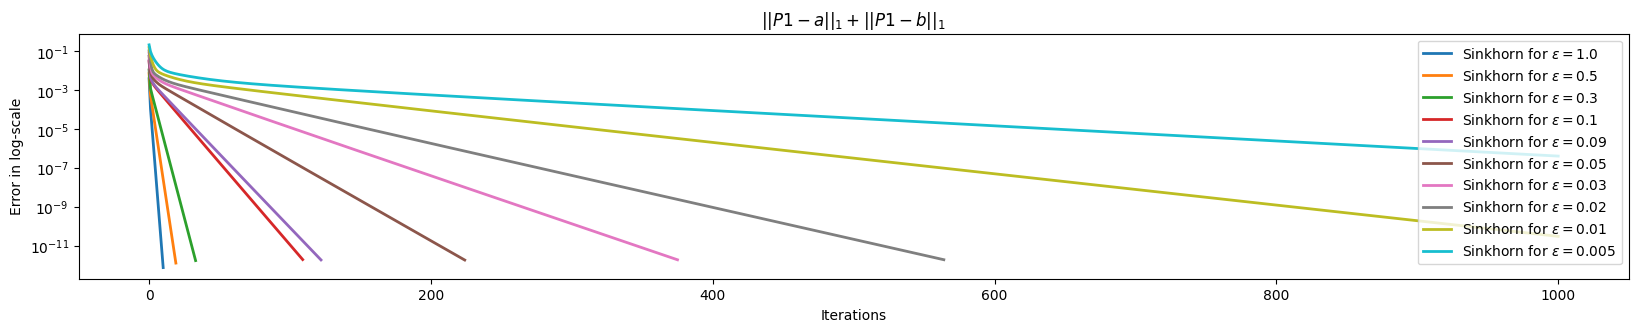

In [97]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label = 'Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")

plt.show()


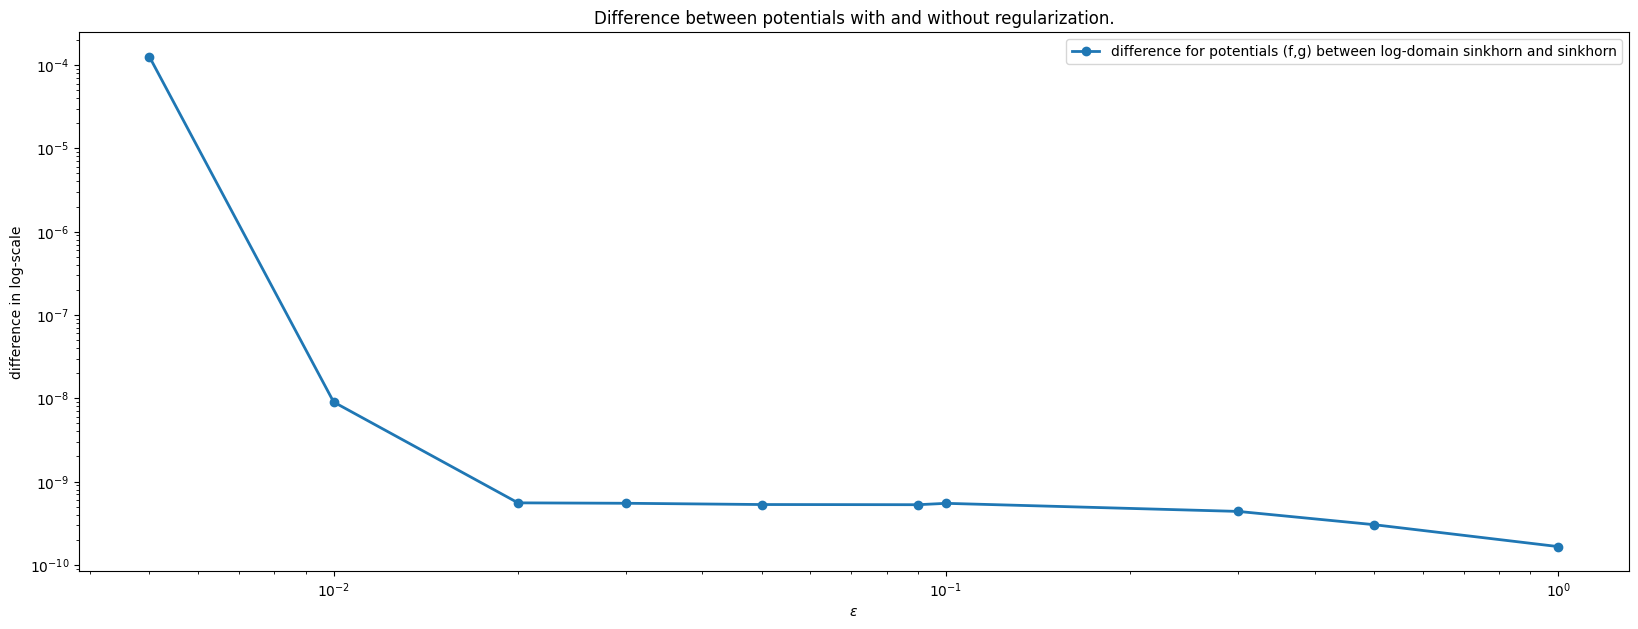

In [98]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "Difference between potentials with and without regularization." )
plt.plot(epsilons, np.array(errors_f) + np.array(errors_g), label = 'difference for potentials (f,g) between log-domain sinkhorn and sinkhorn', linewidth = 2, marker= 'o' )
plt.xlabel("$\epsilon$")
plt.ylabel( "difference in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.show()


# Damped Newton 

In [99]:
rho=0.95
c=0.05
DampedNewtonP=[]
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
# epsilons=[0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
dampednewtonepsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03]
#epsilons=[0.3]
for eps in dampednewtonepsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize(np.ones(N[0]))
    a=a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b=b.reshape(b.shape[0],-1)

    #Kernel
    K=np.exp(-C/eps)
    f,g=a,b

    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating")  
    start=time.time()
    Optimizer=computational_OT.DampedNewton(K,a,b,f,g,eps,rho,c)
    out=Optimizer._update(maxiter=50)
    results_DampedNewton.append(out)
    end=time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")
    
    DampedNewtonP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))
    print( " |- Recording (unstabilized) Hessian \n")

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )


Damped Newton for epsilon=1.0:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.5:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.3:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.1:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.09:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.05:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.03:
Doing for ( 500 600 ).
 |- Ite

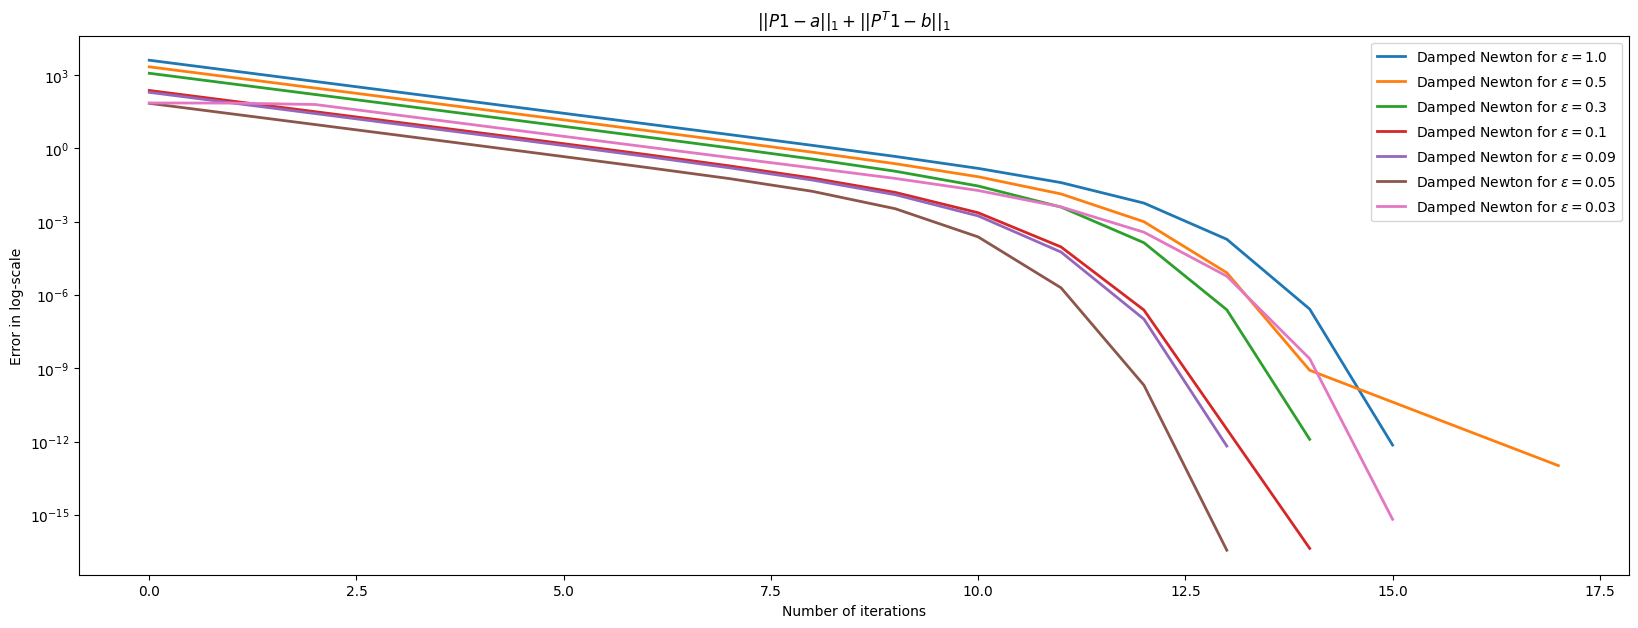


 Error plots can increase! The error is not the objective function!


In [100]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range(len(results_DampedNewton)):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )


In [101]:
fdampednewton, gdampednewton = [], []
for i in range(len(results_DampedNewton)):
    fdampednewton.append(results_DampedNewton[i]['potential_f'])
    gdampednewton.append(results_DampedNewton[i]['potential_g'])
    
unique_dampednewton = []
for i in range(len(results_DampedNewton)):
    unique_dampednewton.append(make_unique_potentials( fdampednewton[i], gdampednewton[i]))

for i in range(len(results_DampedNewton)):
    print( f'''i : {i}''')
    err_f = np.linalg.norm( unique_logSK[i][0] - unique_dampednewton[i][0] )
    err_g = np.linalg.norm( unique_logSK[i][1] - unique_dampednewton[i][1] )

    print( "norm of err_f: ", err_f )
    print( "norm of err_g: ", err_g )
    print( "")

i : 0
norm of err_f:  8.100437494778242e-11
norm of err_g:  2.2329520885397536e-10

i : 1
norm of err_f:  6.1059010205479825e-12
norm of err_g:  1.7229779224518315e-11

i : 2
norm of err_f:  8.263709491307235e-11
norm of err_g:  1.0126844470994744e-10

i : 3
norm of err_f:  1.1981522143091032e-13
norm of err_g:  1.446117350549993e-13

i : 4
norm of err_f:  2.454262163274295e-11
norm of err_g:  2.416520754717978e-12

i : 5
norm of err_f:  1.2653100190100422e-13
norm of err_g:  1.4542063937751992e-13

i : 6
norm of err_f:  1.2901847095557468e-13
norm of err_g:  1.446791209434323e-13



# Damped Newton with Preconditioning


In [102]:
def build_preconditioners( num_eigs,modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort( eigenvalues )
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 13)
    n,m = eigenvectors.shape
    indices=[]
    for i in range(num_eigs//2):
        indices.append(m-i-1)
        indices.append(i+1)
    if num_eigs//2!=0:
        indices.append(m-1-num_eigs//2)
   
    precond_vectors = eigenvectors[:, indices ]
    precond_vectors = []
    for index in indices:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

num_eigs = 13
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1], ansatz=False )

In [103]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.05,0.08,0.1 ]
#precond_epsilons = [ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03]

#epsilons = [ 0.3 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=1.0:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
Damped Newton for epsilon=0.5:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
Damped Newton for epsilon=0.3:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
Damped Newton for epsilon=0.1:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  21
 |- Computing P
Damped Newton for epsilon=0.09:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  24
 |- Computing P
Damped Newton for epsilon=0.05:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  24
 |- Computing P
Damped Newton for epsilon=0.03:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  21
 |- Computing P


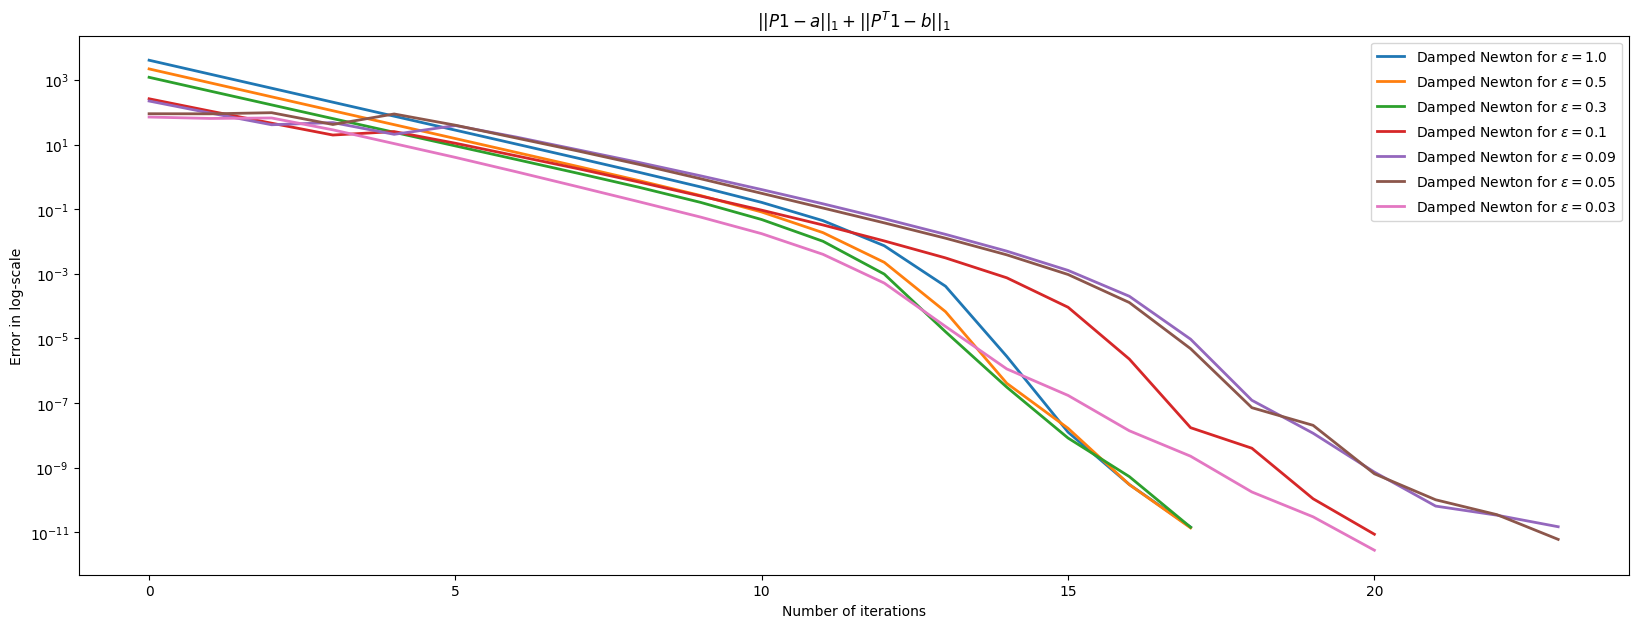


 Error plots can increase! The error is not the objective function!


In [104]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range(len(results_DampedNewton)):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )


In [105]:
fdampednewtonwithprecond, gdampednewtonwithprecond = [], []
for i in range(len(results_DampedNewton)):
    fdampednewtonwithprecond.append(results_DampedNewton[i]['potential_f'])
    gdampednewtonwithprecond.append(results_DampedNewton[i]['potential_g'])
    
unique_dampednewtonwithprecond = []
for i in range(len(results_DampedNewton)):
    unique_dampednewtonwithprecond.append(make_unique_potentials( fdampednewtonwithprecond[i], gdampednewtonwithprecond[i]))


for i in range(len(results_DampedNewton)):
    print( f'''i : {i}''')
    err_f = np.linalg.norm( unique_logSK[i][0] - unique_dampednewtonwithprecond[i][0] )
    err_g = np.linalg.norm( unique_logSK[i][1] - unique_dampednewtonwithprecond[i][1] )
    print( "norm of err_f: ", err_f )
    print( "norm of err_g: ", err_g )
    print( "")

i : 0
norm of err_f:  4.6364454815916255e-09
norm of err_g:  1.6651750616294304e-09

i : 1
norm of err_f:  7.749645569272618e-10
norm of err_g:  1.995762572347328e-09

i : 2
norm of err_f:  1.9463431684195085e-09
norm of err_g:  1.5452055850476904e-09

i : 3
norm of err_f:  9.034216294551669e-10
norm of err_g:  1.2454286308216418e-09

i : 4
norm of err_f:  7.485790916404235e-11
norm of err_g:  4.405895075680063e-10

i : 5
norm of err_f:  3.974537311684156e-11
norm of err_g:  5.0590096704660676e-11

i : 6
norm of err_f:  4.627410453357101e-11
norm of err_g:  4.1630323621489805e-11



In [108]:

# Reality checks
print("For Damped Newton with and without precodnitioning")
for i in range(len(results_DampedNewton)):
    print( f'''i : {i}''')
    # Sums of potentials f_i + g_j
    sum_dampedNewton    = fdampednewton[i][:,None] + gdampednewton[i][None,:]
    sum_dampedNewtonprecond = fdampednewtonwithprecond[i][:,None] + gdampednewtonwithprecond[i][None,:]
    sum_dampedNewton    = sum_dampedNewton.squeeze()
    sum_dampedNewtonprecond = sum_dampedNewtonprecond.squeeze()
    print(sum_dampedNewton.shape,sum_dampedNewtonprecond.shape)
    error     = np.linalg.norm(sum_dampedNewton-sum_dampedNewtonprecond, ord=np.inf)
    print( "Error of sums of potentials : ", error )
    print( "")

For Damped Newton with and without precodnitioning
i : 0
(500, 600) (500, 600)
Error of sums of potentials :  1.8726576378469417e-07

i : 1
(500, 600) (500, 600)
Error of sums of potentials :  4.879957948844549e-08

i : 2
(500, 600) (500, 600)
Error of sums of potentials :  8.015007768591431e-08

i : 3
(500, 600) (500, 600)
Error of sums of potentials :  3.948112914375912e-08

i : 4
(500, 600) (500, 600)
Error of sums of potentials :  1.3297024398228885e-08

i : 5
(500, 600) (500, 600)
Error of sums of potentials :  5.366250221960911e-09

i : 6
(500, 600) (500, 600)
Error of sums of potentials :  1.911604582960358e-09



# Comparison plot for comparing the Kantorovich potentials against the ground truth: log-domain Sinkhorn


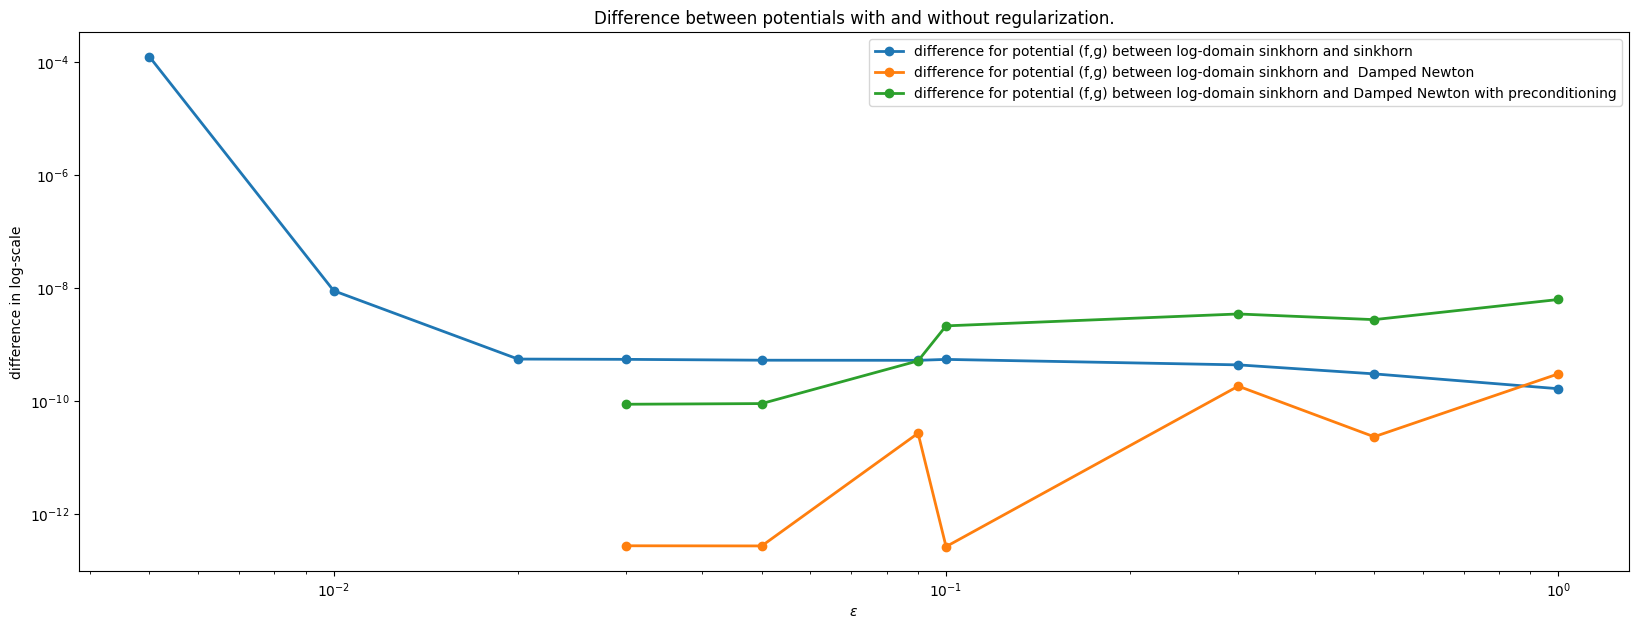

In [107]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "Difference between potentials with and without regularization." )


difference_f = []
difference_g = []
for i in  range(len(results_Sinkhorn)):
    difference_f.append(np.linalg.norm(unique_logSK[i][0]-unique_SK[i][0]))
for i in  range(len(results_Sinkhorn)):
    difference_g.append(np.linalg.norm(unique_logSK[i][1]-unique_SK[i][1])) 
plt.plot(epsilons, np.array(difference_f)+np.array(difference_g),  label = 'difference for potential (f,g) between log-domain sinkhorn and sinkhorn', linewidth = 2, marker= 'o' )


difference_f = []
difference_g = []
for i in  range(len(results_DampedNewton)):
    difference_f.append(np.linalg.norm(unique_logSK[i][0]-unique_dampednewton[i][0]))
for i in  range(len(results_DampedNewton)):
    difference_g.append(np.linalg.norm(unique_logSK[i][1]-unique_dampednewton[i][1]))
plt.plot(epsilons[:-3], np.array(difference_f)+np.array(difference_g), label = 'difference for potential (f,g) between log-domain sinkhorn and  Damped Newton', linewidth = 2, marker= 'o' )


difference_f = []
difference_g = []
for i in  range(len(results_DampedNewton)):
    difference_f.append(np.linalg.norm(unique_logSK[i][0]-unique_dampednewtonwithprecond[i][0]))
for i in  range(len(results_DampedNewton)):
    difference_g.append(np.linalg.norm(unique_logSK[i][1]-unique_dampednewtonwithprecond[i][1]))
plt.plot(epsilons[:-3], np.array(difference_f)+ np.array(difference_g), label = 'difference for potential (f,g) between log-domain sinkhorn and Damped Newton with preconditioning', linewidth = 2, marker= 'o' )

plt.xlabel("$\epsilon$")
plt.ylabel( "difference in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.xscale('log')
plt.show()
